<a href="https://colab.research.google.com/github/dhirajwagh1612/dhirajwagh1612/blob/main/Computer_Vision_GL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DOMAIN**:  Botanical Research

**CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various  stages  of  growth.  They  already  have  have  invested  on  curating  sample  images.  They  require  an  automation  which  can  create  a classifier capable of determining a plant's species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

**PROJECT OBJECTIVE:** To create a classifier capable of determining a plant's species from a photo.

**Steps and tasks:**

In [7]:
cd "/content/drive/MyDrive/datasets/GL_kaggle"

/content/drive/MyDrive/datasets/GL_kaggle


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV
import tensorflow as tf

In [12]:
image_size = 256
batch_size = 32

In [13]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20, # You can uncomment these parameters to make you generator rotate & flip the images to put the train model in stricter conditions.
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [15]:
train_path = "/content/drive/MyDrive/datasets/GL_kaggle/plant-seedlings-classification.zip"

In [16]:
!mkdir temp_train

In [17]:
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

In [ ]:
train_gen = idg.flow_from_directory('/content/temp_train/plant-seedlings-classification/train/*',
                                                    target_size=(image_size, image_size),
                                                    subset='training',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=1
                                                )

In [ ]:
val_gen = idg.flow_from_directory('/content/temp_train/plant-seedlings-classification/train',
                                                   target_size=(image_size, image_size),                                                   
                                                   subset='validation',
                                                   class_mode='categorical',
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   seed=1
                                                )

In [ ]:
x,y = next(train_gen)

In [19]:
paths = glob.glob("/content/temp_train/plant-seedlings-classification/train*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format(label_names))

Total labels: 0
Labels: []


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_grid(image_list, nrows, ncols, label_list=None, show_labels=False, figsize=(10,10)):

    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(nrows, ncols),  
                     axes_pad=0.2, 
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis('off')

In [ ]:
show_grid(x,2,4,show_labels=True,figsize=(10,10))

In [ ]:
model = tf.keras.models.Sequential()

# Input layer
# Can be omitted, you can specify the input_shape in other layers
model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# You can save the best model to the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('plant_classifier.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [ ]:
history = model.fit(train_gen,
          epochs=20, # Increase number of epochs if you have sufficient hardware
          steps_per_epoch= 3803//batch_size,  # Number of train images // batch_size
          validation_data=val_gen,
          validation_steps = 947//batch_size, # Number of val images // batch_size
          callbacks = [checkpoint],
          verbose = 1
)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,21)))
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/temp_train/plant-seedlings-classification/train/.jpg',target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = cnn.predict(test_image)
train_set.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
print(prediction)

**Part B**

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 17 plant species.

**PROJECT OBJECTIVE:** To experiment with various approaches to train an image classifier to predict type of flower from the image.

**Steps and tasks:**

1. Import and Understand the data

      A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [1]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [2]:
pip install tflearn

     |████████████████████████████████| 107 kB 5.5 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=a7328648b31f1b5190d8dffdf630c52e548dce12a51a84d32f9c67ba922a142d
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [3]:
import tflearn.datasets.oxflower17 as oxflower17
from sklearn.model_selection import train_test_split
X, y = oxflower17.load_data(resize_pics=(224,224))

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [4]:
X[0].min(), X[0].max()

(0.0, 1.0)

In [5]:
X.shape, y.shape

((1360, 224, 224, 3), (1360,))

Text(0.5, 1.0, 'Displaying a random image')

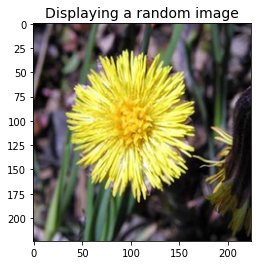

In [6]:
plt.imshow(X[50])
plt.title("Displaying a random image", fontsize=14)

In [7]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [13 13  0 ... 12  7 15]


IndexError: ignored

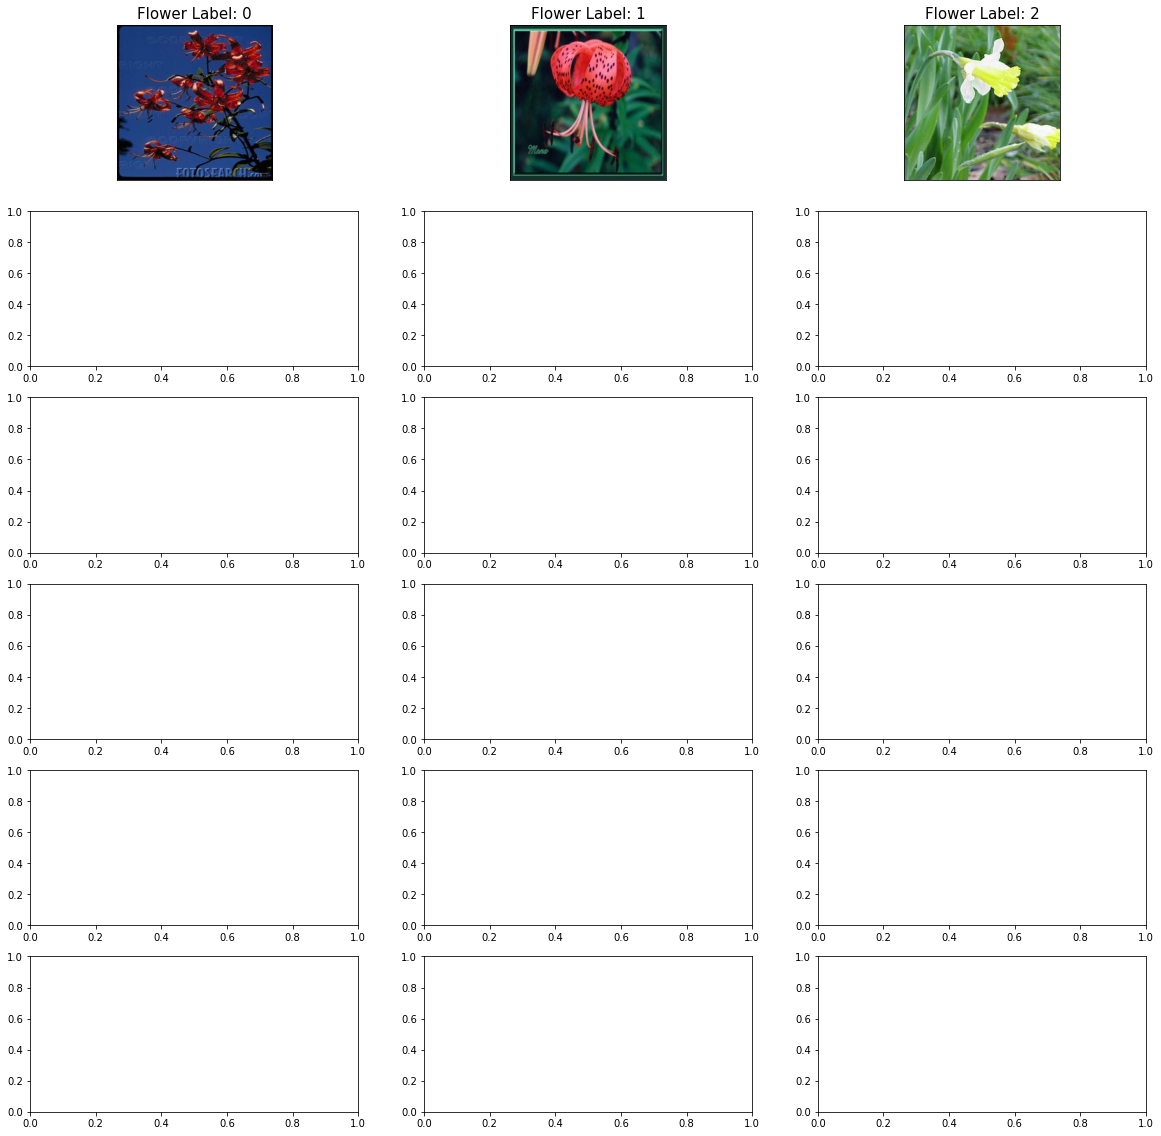

In [8]:
cols = 3
rows = int(np.ceil(len(np.unique(y))/cols))

fig, ax = plt.subplots(rows, cols, figsize=(20,20))
for i in np.unique(y):
  col = i % 5
  row = int(i/5)

  ax[row][col].imshow(X[i])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Flower Label: {i}",{'fontsize':15})
plt.show() 

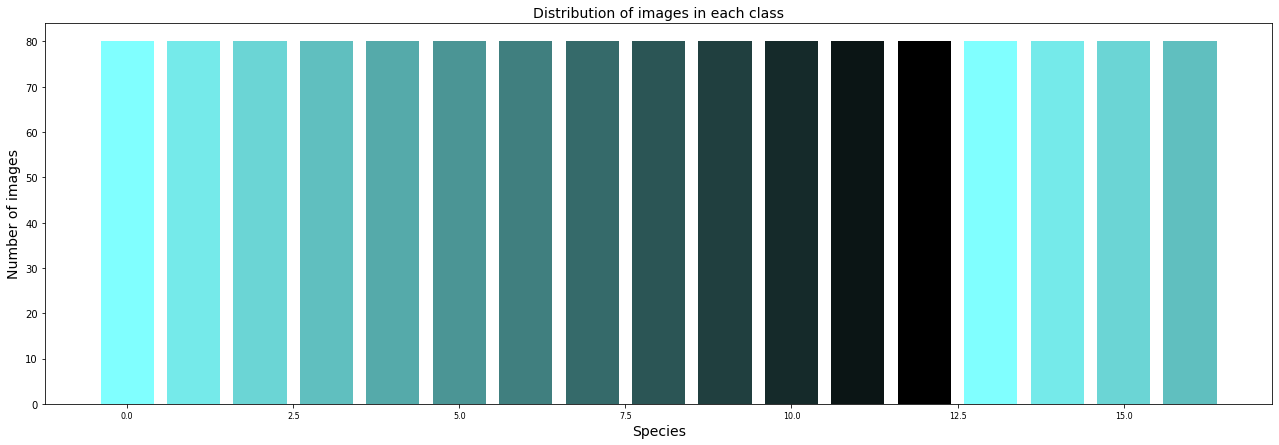

In [9]:
values =[]
labels=[]
for label in set(y):
  values.append(len(X[y == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 0, 0.5),
                (1.0, 0, .5)],
        "green": [(0, 0.5, 1.0),
                  (1.0, 0, 0)],
        "blue": [(0, 1.0, 1.0),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

In [11]:
#Image Preprocessing

In [12]:
#Converting images from RGB to HSV and applying mophological transformations

In [13]:
#Applying Segmentation

In [14]:
def segment_plant(image):
    output = cv2.bitwise_and(image, image)
    return output

In [15]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [102]:
def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

In [17]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


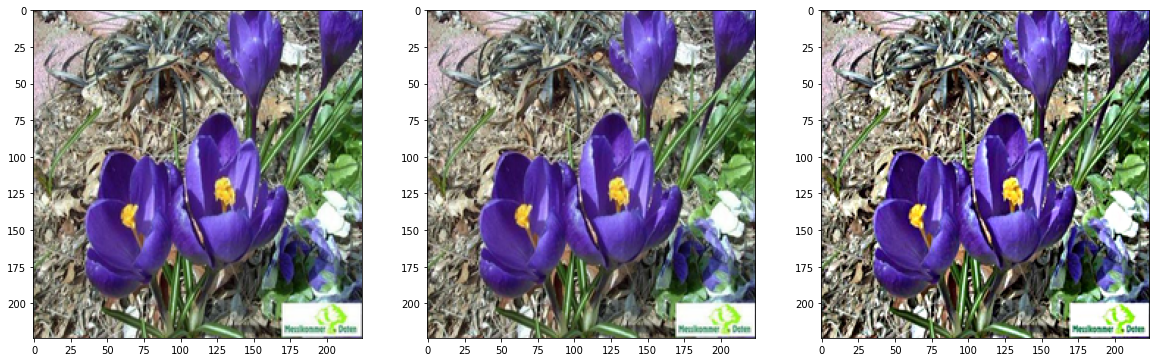

In [18]:
images = np.array(X)
classes = np.array(y)
image = X[25]


image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_segmented)
axs[2].imshow(image_sharpen)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [21]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (952, 224, 224, 3),(204, 224, 224, 3),(204, 224, 224, 3)


In [22]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (952,),(204,),(204,)


In [23]:
num_classes = len(np.unique(y_train))
num_classes

17

In [24]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

50176


In [25]:
import pandas as pd

In [26]:
model_performance_b = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [27]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [28]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [29]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((204, 50176), (204, 50176), (204, 50176))

In [30]:
from sklearn.decomposition import PCA as RandomizedPCA

In [31]:
n_components = 150
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [32]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [33]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9637477, 0.96270484, 0.97639424)

In [34]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [35]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((204, 450), (204,))

In [36]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [37]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

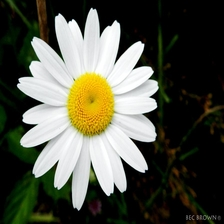

The shape of image to be predicted is:'(224, 224, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 224, 224, 3)'


In [39]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread('/content/Prediction.jpg')
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [40]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [41]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [42]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'11'


In [43]:
model_performance_b = model_performance_b.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.117647,NA,11


In [44]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [45]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'7'


In [46]:
model_performance_b = model_performance_b.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.117647,NA,11
1,RF,0.161765,NA,7


In [47]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             verbose=10)

In [48]:
dt_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

The predicted label is:'7'


In [49]:
model_performance_b = model_performance_b.append({'Model':'DT',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.117647,NA,11
1,RF,0.161765,NA,7
2,DT,0.127451,NA,7


In [50]:
#Classification using Artificial Neural Network (ANN)

In [51]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

In [52]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [54]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [55]:
X_train.shape,y_train.shape

((952, 224, 224, 3), (952,))

In [56]:
from tensorflow import keras

In [57]:
def ann_model(height, width, num_channels, num_classes, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = keras.Sequential()

  model.add(tf.keras.layers.InputLayer(input_shape=(height, width, num_channels)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))
  opt = tf.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

In [58]:
ann = ann_model(224,224,3,17)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 batch_normalization (BatchN  (None, 150528)           602112    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              154141696 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 300)

Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - 4s 4ms/sample - loss: 3.5604 - acc: 0.0830 - val_loss: 2.8689 - val_acc: 0.0490
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


952/952 [==============================] - 1s 1ms/sample - loss: 3.3342 - acc: 0.0935 - val_loss: 2.8402 - val_acc: 0.0588
Epoch 3/50
952/952 [==============================] - 1s 1ms/sample - loss: 3.1293 - acc: 0.1261 - val_loss: 2.8170 - val_acc: 0.0490
Epoch 4/50
952/952 [==============================] - 1s 1ms/sample - loss: 2.9672 - acc: 0.1408 - val_loss: 2.7933 - val_acc: 0.0588
Epoch 5/50
952/952 [==============================] - 1s 1ms/sample - loss: 2.8314 - acc: 0.1681 - val_loss: 2.7740 - val_acc: 0.0735
Epoch 6/50
952/952 [==============================] - 1s 1ms/sample - loss: 2.7176 - acc: 0.2132 - val_loss: 2.7550 - val_acc: 0.0980
Epoch 7/50
952/952 [==============================] - 1s 1ms/sample - loss: 2.6185 - acc: 0.2311 - val_loss: 2.7379 - val_acc: 0.1127
Epoch 8/50
952/952 [==============================] - 1s 1ms/sample - loss: 2.4806 - acc: 0.2489 - val_loss: 2.7216 - val_acc: 0.1225
Epoch 9/50
952/952 [==============================] - 1s 1ms/sample - los

In [60]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

Test loss: 2.2062717863157686
Test accuracy: 0.31862745


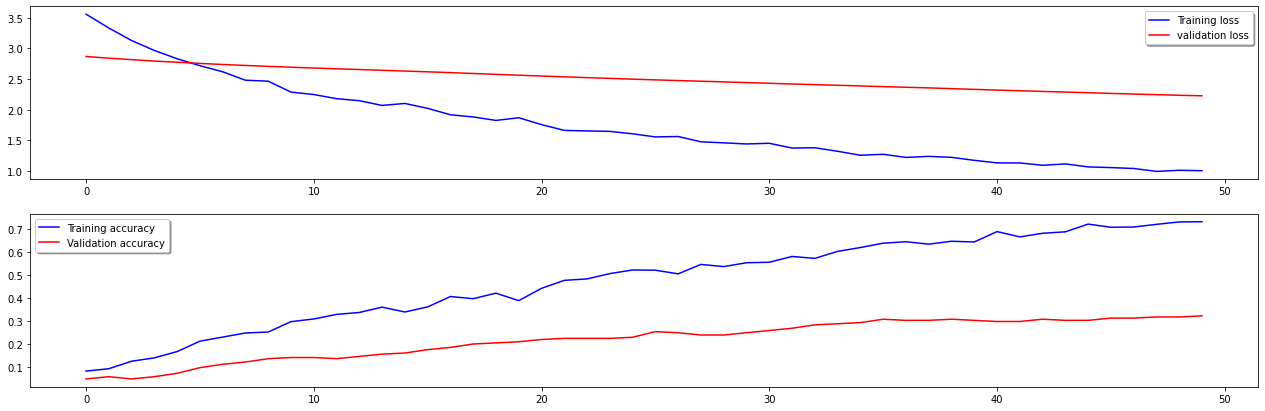

In [61]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [62]:
ann_predict = np.argmax(ann.predict(img_predict))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [63]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 12


In [64]:
model_performance_b = model_performance_b.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.117647,NA,11
1,RF,0.161765,NA,7
2,DT,0.127451,NA,7
3,ANN,0.318627,2.206272,12


In [65]:
# Classification using Convolution Neural Network (CNN)

In [77]:
def cnn_model(height, width, num_channels, num_classes, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))


  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.4))



  model.add(tf.keras.layers.GlobalMaxPooling2D())
  model.add(tf.keras.layers.Dense(256, activation = "relu"))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

  opt = tf.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)
  model.summary()
  return model

In [78]:
cnn = cnn_model(224,224,3,17)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 17)                4369      
                                                                 
Total params: 342,321
Trainable params: 342,321
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - ETA: 0s - loss: 2.8515 - acc: 0.0588

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


952/952 [==============================] - 36s 38ms/sample - loss: 2.8515 - acc: 0.0588 - val_loss: 2.8321 - val_acc: 0.0539
Epoch 2/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8461 - acc: 0.0620 - val_loss: 2.8321 - val_acc: 0.0539
Epoch 3/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8431 - acc: 0.0620 - val_loss: 2.8321 - val_acc: 0.0539
Epoch 4/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8388 - acc: 0.0662 - val_loss: 2.8321 - val_acc: 0.0490
Epoch 5/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8550 - acc: 0.0567 - val_loss: 2.8322 - val_acc: 0.0490
Epoch 6/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8528 - acc: 0.0494 - val_loss: 2.8322 - val_acc: 0.0490
Epoch 7/50
952/952 [==============================] - 12s 13ms/sample - loss: 2.8516 - acc: 0.0483 - val_loss: 2.8322 - val_acc: 0.0490
Epoch 8/50
952/952 [==============================] - 12s 1

In [81]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

Test loss: 2.8343086990655637
Test accuracy: 0.073529415


In [82]:
cnn_predict = np.argmax(cnn.predict(img_predict))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [83]:
model_performance_b = model_performance_b.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.117647,NA,11
1,RF,0.161765,NA,7
2,DT,0.127451,NA,7
3,ANN,0.318627,2.206272,12
4,CNN,0.073529,2.834309,11


In [85]:
from keras.preprocessing.image import ImageDataGenerator

In [86]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [91]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#epochs = 30
#batch_size = 38

In [92]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=100),
                              epochs = 50, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 100
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
9/9 - 20s - loss: 2.8332 - acc: 0.0552 - val_loss: 2.8335 - val_acc: 0.0539 - lr: 1.0000e-06 - 20s/epoch - 2s/step
Epoch 2/50
9/9 - 15s - loss: 2.8430 - acc: 0.0610 - val_loss: 2.8336 - val_acc: 0.0539 - lr: 1.0000e-06 - 15s/epoch - 2s/step
Epoch 3/50
9/9 - 17s - loss: 2.8386 - acc: 0.0646 - val_loss: 2.8324 - val_acc: 0.0539 - lr: 1.0000e-06 - 17s/epoch - 2s/step
Epoch 4/50
9/9 - 18s - loss: 2.8370 - acc: 0.0657 - val_loss: 2.8336 - val_acc: 0.0539 - lr: 1.0000e-06 - 18s/epoch - 2s/step
Epoch 5/50
9/9 - 17s - loss: 2.8402 - acc: 0.0511 - val_loss: 2.8336 - val_acc: 0.0539 - lr: 1.0000e-06 - 17s/epoch - 2s/step
Epoch 6/50
9/9 - 13s - loss: 2.8326 - acc: 0.0704 - val_loss: 2.8336 - val_acc: 0.0539 - lr: 1.0000e-06 - 13s/epoch - 1s/step
Epoch 7/50
9/9 - 15s - loss: 2.8371 - acc: 0.0599 - val_loss: 2.8336 - val_acc: 0.0539 - lr: 1.0000e-06 - 15s/epoch - 2s/step
Epoch 8/50
9/9 - 16s - loss: 2.8420 - acc: 0.0622 - val_loss: 2.8337 - val_acc: 0.0490 - lr: 1.0000e-06 - 16s/epoch - 

In [93]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

Test loss: 2.8340947908513687
Test accuracy: 0.04901961


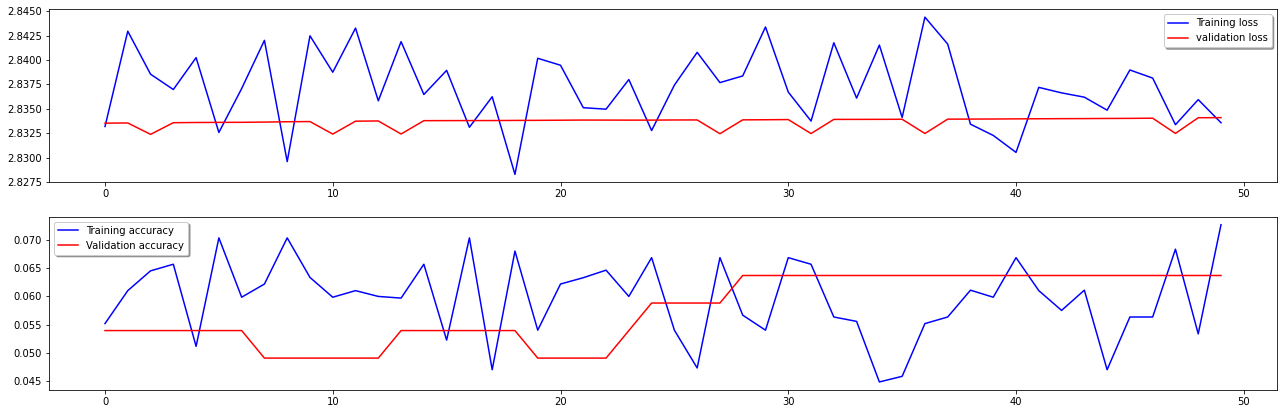

In [96]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [102]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [100]:
cnn_predict_aug = np.argmax(cnn.predict(img_predict))

In [101]:
print('The predicted flower is with label:', cnn_predict)

The predicted flower is with label: 11
